# Import

In [1]:
import os
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn.utils import resample
from scipy.ndimage import gaussian_filter
import warnings
warnings.filterwarnings("ignore")

/ottomo/anaconda3/envs/tf1py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/ottomo/anaconda3/envs/tf1py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/ottomo/anaconda3/envs/tf1py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/ottomo/anaconda3/envs/tf1py37/lib/python3.7/site-packages

In [2]:
## our functions
from utils import plot_num_of_classes, split, upsample
from Models.utils import evaluate_model, confustion_matrix, plot_confusion_matrix

# Data Files Check and Load

In [3]:
for dirname, _, filenames in os.walk("../Data"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../Data/ptbdb_normal.csv
../Data/mitbih_test.csv
../Data/ecg_rr.csv
../Data/label_RR_nonempty.csv
../Data/label_rr.csv
../Data/ecg_signal_raw.csv
../Data/ecg_RR_kurz.csv
../Data/ptbdb_abnormal.csv
../Data/ecg_rr_kurz.csv
../Data/ecg_RR.csv
../Data/ecg_signal.csv
../Data/label_rr_kurz.csv
../Data/label_RR_kurz.csv
../Data/label_RR.csv
../Data/label.csv
../Data/ecg_RR_nonempty.csv
../Data/mitbih_train.csv


In [4]:
### read one dataset 
## to see how the datasets are made --> RawData_split.py and RawData_split_10secs.py
# here we use the sample size 256 of one data 
data = "../Data/ecg_RR_kurz.csv"
label = "../Data/label_RR_kurz.csv"
dataset = pd.read_csv(data)
labelset = pd.read_csv(label)

In [5]:
## check if there is any empty sample
idx = []
for i in range(dataset.shape[0]):
    if np.max(dataset.iloc[i, 1:]) == 0:
        idx.append(i)
## drop the empty samples
dataset = dataset.drop(dataset.index[idx])
labelset = labelset.drop(labelset.index[idx])

In [6]:
## store them for the future use
dataset.to_csv("../Data/ecg_RR_nonempty.csv", index= True, index_label=True)
labelset.to_csv("../Data/label_RR_nonempty.csv", index= True, index_label=True)

# Data View

In [7]:
## take a look at the sizes of each class
labelset = labelset.rename(columns={'0':'label'})
label = labelset['label'].astype(int)
label = label.value_counts()
print(label)

0    91095
4     8059
2     7616
1     2671
3      813
Name: label, dtype: int64


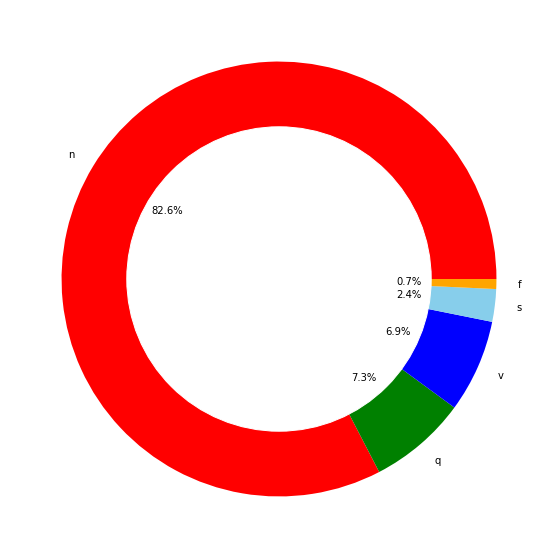

In [8]:
## and we can plot it as a circle 
plot_num_of_classes(label)
## we can see the huge unbalance between the classes

In [9]:
## merge the label to the last column of the dataset 
## just for convenience
dataset = pd.concat([dataset, labelset['label']], axis=1, sort=False)
dataset.head()

,True,0,1,2,3,4,5,6,7,8,...,247,248,249,250,251,252,253,254,255,label
0,0,0.585542,0.586747,0.581928,0.581928,0.580723,0.583133,0.581928,0.579518,0.579518,...,0.577108,0.574699,0.574699,0.577108,0.579518,0.581928,0.581928,0.577108,0.577108,0.0
1,1,0.573494,0.574699,0.575904,0.571084,0.569880,0.571084,0.573494,0.574699,0.574699,...,0.581928,0.581928,0.579518,0.579518,0.579518,0.578313,0.581928,0.580723,0.578313,0.0
2,2,0.567470,0.568675,0.566265,0.568675,0.569880,0.572289,0.568675,0.569880,0.566265,...,0.583133,0.583133,0.584337,0.586747,0.584337,0.583133,0.579518,0.583133,0.585542,0.0
3,3,0.574699,0.578313,0.577108,0.577108,0.574699,0.571084,0.572289,0.573494,0.574699,...,0.579518,0.580723,0.579518,0.578313,0.577108,0.578313,0.580723,0.580723,0.583133,0.0
4,4,0.577108,0.578313,0.573494,0.573494,0.571084,0.573494,0.575904,0.574699,0.578313,...,0.584337,0.584337,0.579518,0.583133,0.585542,0.586747,0.581928,0.584337,0.583133,0.0


# Split the Dataset 

In [10]:
label = dataset['label']
label = label.to_numpy()
dataset = dataset.to_numpy()
dataset = dataset[:, 1:]
print(dataset)

[[0.58554217 0.58674699 0.58192771 ... 0.57710843 0.57710843 0.        ]
 [0.57349398 0.5746988  0.57590361 ... 0.58072289 0.57831325 0.        ]
 [0.56746988 0.5686747  0.56626506 ... 0.58313253 0.58554217 0.        ]
 ...
 [0.42465753 0.41917808 0.42374429 ... 0.42648402 0.42739726 0.        ]
 [0.4283105  0.43013699 0.43013699 ... 0.44018265 0.44292237 0.        ]
 [0.44748858 0.44748858 0.44474886 ... 0.42009132 0.41917808 0.        ]]


In [11]:
# use our split function 
(train, train_label), (validation, validation_label), (test, test_label) = split(dataset)

number of class : 91095
number of train data per class 90895
90895
number of class : 2671
number of train data per class 2471
2471
number of class : 7616
number of train data per class 7416
7416
number of class : 813
number of train data per class 613
613
number of class : 8059
number of train data per class 7859
7859


# Upsample

In [12]:
## we can do the upsample to reduce the impact of the unbalance between the classees
## to our dataset
## but only do on the training data
train = upsample(train)

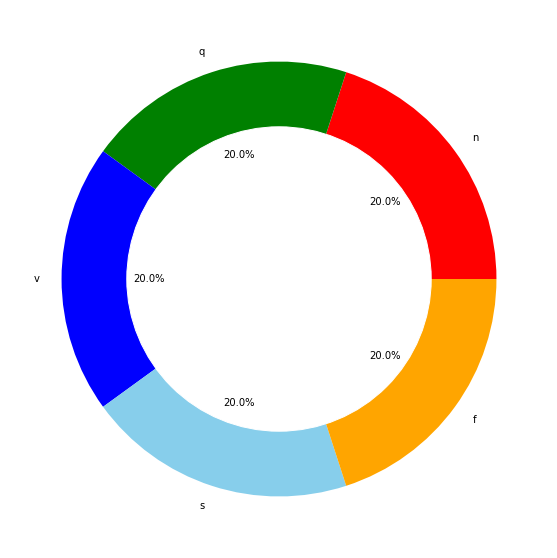

In [13]:
## and we can plot again it as a circle 
equilibre = train[len(train.columns) - 1].value_counts()
plot_num_of_classes(equilibre)

# Training

In [14]:
## prepare data and label
train_label = train[len(train.columns) - 1]
train_label = to_categorical(train_label)
validation_label = to_categorical(validation_label)
test_label = to_categorical(test_label)

X_train = train.iloc[:, :len(train.columns)- 1].values
train = X_train.reshape(len(X_train), X_train.shape[1], 1)
validation = validation.reshape(len(validation), validation.shape[1], 1)
test = test.reshape(len(test), test.shape[1], 1)

# Model with time dependence

In [16]:
from Models.time_depends import time_depends
model_hiker, history_hiker = time_depends(train, train_label, validation, validation_label)

100000/100000 [==============================] - 18s 184us/sample - loss: 0.1039 - acc: 0.9653 - val_loss: 0.1582 - val_acc: 0.9520
Epoch 6/55
100000/100000 [==============================] - 19s 186us/sample - loss: 0.0926 - acc: 0.9693 - val_loss: 0.1615 - val_acc: 0.9560
Epoch 7/55
100000/100000 [==============================] - 18s 184us/sample - loss: 0.0892 - acc: 0.9710 - val_loss: 0.1971 - val_acc: 0.9460
Epoch 8/55
100000/100000 [==============================] - 18s 178us/sample - loss: 0.0766 - acc: 0.9748 - val_loss: 0.1769 - val_acc: 0.9440
Epoch 9/55
100000/100000 [==============================] - 18s 184us/sample - loss: 0.0855 - acc: 0.9718 - val_loss: 0.1561 - val_acc: 0.9480
Epoch 10/55
100000/100000 [==============================] - 18s 178us/sample - loss: 0.0776 - acc: 0.9745 - val_loss: 0.1507 - val_acc: 0.9580
Epoch 11/55
100000/100000 [==============================] - 18s 176us/sample - loss: 0.0838 - acc: 0.9730 - val_loss: 0.2034 - val_acc: 0.9520
Epoch 12

Accuracy: 96.40%


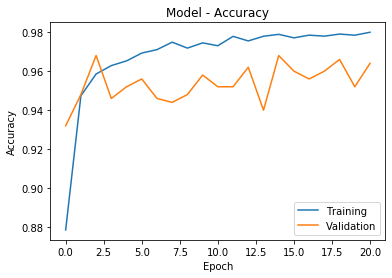

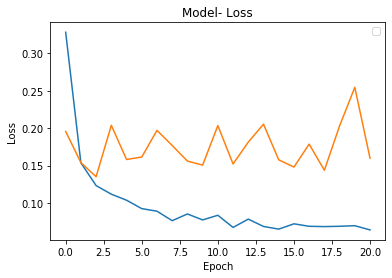

the prediction on the validation data [[9.9951172e-01 4.8724780e-04 8.4930326e-07 2.1151425e-08 2.5175078e-07]
 [9.9999785e-01 1.1862780e-06 8.5300792e-07 1.3263953e-07 1.6211011e-09]
 [9.9999499e-01 4.9652244e-06 1.1517819e-08 1.0979405e-11 4.1317008e-10]
 ...
 [2.3493097e-07 9.5282660e-10 4.2369726e-07 1.9202596e-07 9.9999917e-01]
 [5.0450590e-09 6.3376436e-13 8.3930772e-11 2.3604652e-10 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00]]
Normalized confusion matrix


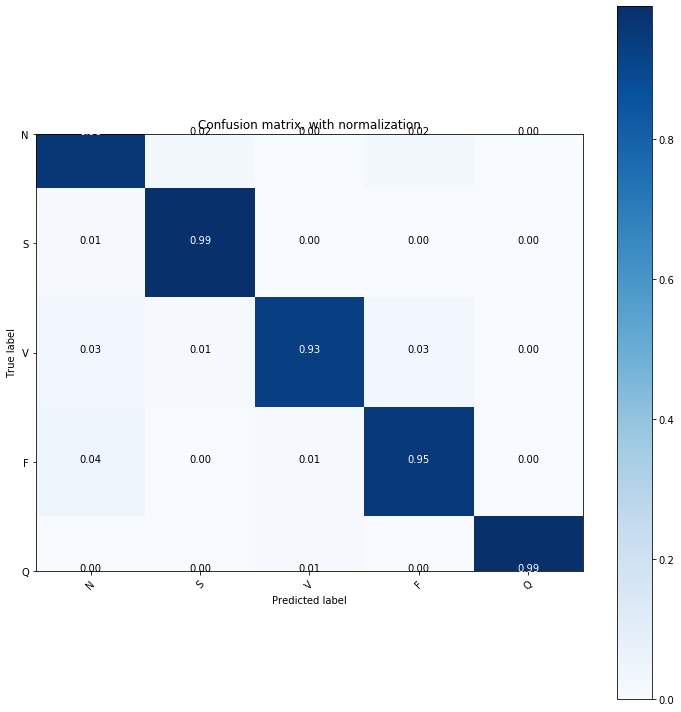

In [17]:
evaluate_model(history_hiker, validation, validation_label, model_hiker)
validation_pred_hiker = model_hiker.predict(validation)
print("the prediction on the validation data", validation_pred_hiker)

cnf_matrix = confusion_matrix(validation_label.argmax(axis=1), validation_pred_hiker.argmax(axis=1))

plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')

In [18]:
#evaluate on test set
score_hiker = model_hiker.evaluate(test, test_label)
print('loss, acc', score_hiker)

500/500 [==============================] - 0s 66us/sample - loss: 0.2187 - acc: 0.9600
loss, acc [0.2186663027405772, 0.96]


# Model with deep Conv1d 

In [15]:
from Models.deep_conv1d import network
model_net, history_net = network(train, train_label, validation, validation_label)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs_cnn (InputLayer)      (None, 256, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 256, 32)           1312      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 128, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 32)           40992     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 64, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 64, 32)            40992     
_________________________________________________________________
max_

Accuracy: 97.00%


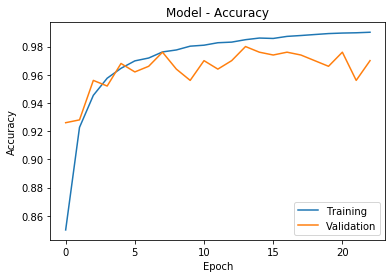

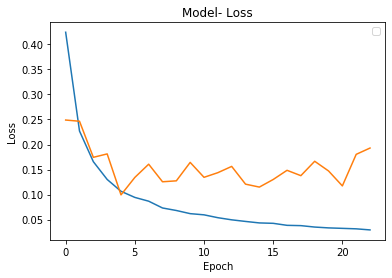

the prediction on the validation data [[9.9937111e-01 5.9399445e-04 3.1122952e-05 2.7327524e-06 1.0268619e-06]
 [9.9987161e-01 3.7497044e-05 1.1252074e-05 7.2886636e-05 6.7247597e-06]
 [9.9999988e-01 9.0745371e-12 2.0885385e-09 2.3929108e-08 6.8043754e-08]
 ...
 [8.6059146e-07 2.2478721e-17 1.8196754e-08 2.0252931e-07 9.9999893e-01]
 [1.8151086e-08 1.4301979e-19 1.7557164e-09 3.7036532e-09 1.0000000e+00]
 [8.9720679e-08 1.9977826e-18 1.0413971e-08 1.5764943e-08 9.9999988e-01]]
Normalized confusion matrix


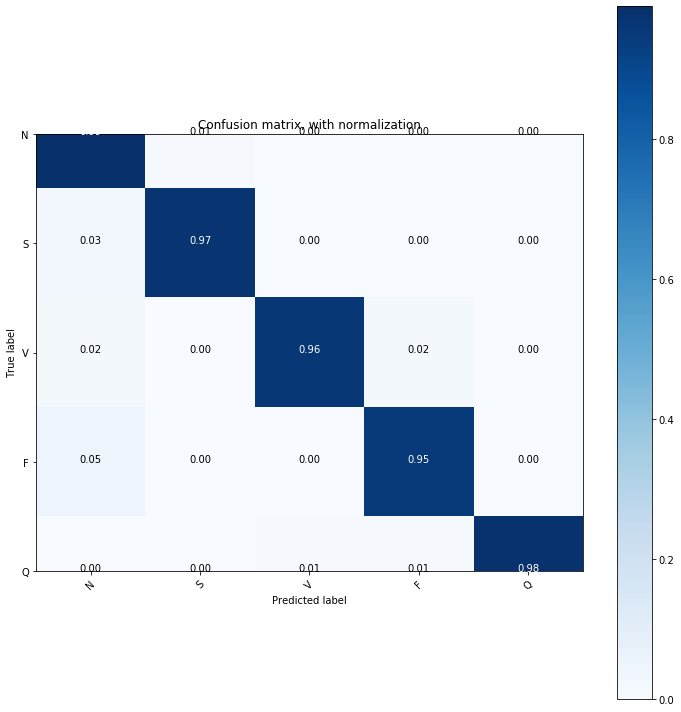

In [16]:
evaluate_model(history_net, validation, validation_label, model_net)
validation_pred = model_net.predict(validation)
print("the prediction on the validation data", validation_pred)

cnf_matrix = confusion_matrix(validation_label.argmax(axis=1), validation_pred.argmax(axis=1))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')

In [17]:
## evaluate again on the test data
score_kn7 = model_net.evaluate(test, test_label)
print('loss, acc', score_kn7)

500/500 [==============================] - 0s 59us/sample - loss: 0.1511 - acc: 0.9740
loss, acc [0.15105230309679063, 0.974]
